# Hello Numerai

In this notebook we will go through the basics of the tournament
1. Dataset: how to download the dataset and understand its basic structure
2. Modeling: how to train our first model 
3. Submissions: how to upload our model to make live submissions

In [31]:
# Install dependencies
!pip install -q numerapi pandas matplotlib lightgbm pyarrow cloudpickle

## 1. Dataset  

Let's download the dataset and get familar with its basic structure. 


In [32]:
# Numerai API is the official Python API client for Numerai
# We will be using it to download the dataset
from numerapi import NumerAPI
napi = NumerAPI()

# v4.1 is the latest version of the dataset
# Let's see what files are available for download
[f for f in napi.list_datasets() if f.startswith("v4.1")]

['v4.1/features.json',
 'v4.1/live.parquet',
 'v4.1/live_example_preds.csv',
 'v4.1/live_example_preds.parquet',
 'v4.1/live_int8.parquet',
 'v4.1/meta_model.parquet',
 'v4.1/train.parquet',
 'v4.1/train_int8.parquet',
 'v4.1/validation.parquet',
 'v4.1/validation_example_preds.csv',
 'v4.1/validation_example_preds.parquet',
 'v4.1/validation_int8.parquet']

In this example, we will focus on the following files:
- `features.json`: feature metadata
- `train.parquet`: historical data for training our model
- `valdation.parquet`: hold out historical data for evaluating our model
- `live.parquet`: live features for making submissions

In [33]:
# Let's download the training data and feature metadata files
# This will take about 1 minute 🍵
napi.download_dataset("v4.1/train.parquet");
napi.download_dataset("v4.1/features.json");

2023-04-17 16:08:51,121 INFO numerapi.utils: target file already exists
2023-04-17 16:08:51,122 INFO numerapi.utils: download complete
2023-04-17 16:08:51,514 INFO numerapi.utils: target file already exists
2023-04-17 16:08:51,516 INFO numerapi.utils: download complete


In [34]:
import pandas as pd
import json

# The feature metadata file contains a lot of useful information about the features
# In particular, it defines various feature sets that are useful for training smaller models
# In this example, we will be using the "small" feature set to save time and memory 
# In practice, you will probably want to use all the features to maximize your model's performance 
feature_metadata = json.load(open("v4.1/features.json")) 
feature_cols = feature_metadata["feature_sets"]["small"]

# Load the training data but only the "small" subset of features
training_data = pd.read_parquet("v4.1/train.parquet", columns= ["era"] + feature_cols + ["target"]) 

In [35]:
# Let's take a look at the training data
# We limit the number of rows and columns displayed to make it easier to read
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 5)
training_data

,era,feature_bijou_penetrant_syringa,...,feature_unventilated_sollar_bason,target
id,,,,,
n003bba8a98662e4,0001,0.00,...,0.00,0.25
n003bee128c2fcfc,0001,0.50,...,0.25,0.75
n0048ac83aff7194,0001,0.25,...,1.00,0.50
n00691bec80d3e02,0001,0.75,...,0.75,0.75
n00b8720a2fdc4f2,0001,0.00,...,0.00,0.75
...,...,...,...,...,...
nffcc1dbdf2212e6,0574,1.00,...,1.00,0.75
nffd71b7f6a128df,0574,0.75,...,0.50,0.00
nffde3b371d67394,0574,0.75,...,1.00,0.25


At a high level, each row represents a stock on a specific date
- `id`: obfuscated stock id, unique across different dates
- `era`: obfuscated date, chronological and each one week apart
- `features`: obfuscated stock features known on the date
- `target`: 20 day subsequent specific return of the stock from the date

For example
- `n003bba8a98662e4` in era `0001` could be "TSLA on Jan 31st 2019" 
- `feature_bijou_penetrant_syringa=0.00` could mean "P/E ratio in bottom 20th percentile"
- `feature_unventilated_sollar_bason=0.00` could mean "6 month trailing momentum in bottom 20th percentile"
- `target=0.25` could mean "20 day subsequent specific return in the bottom 40th percentile"

Don't worry if you don't know what some of this means. No financial domain knowledge is required to work with this dataset. References to the underlying financial concepts are only made to help you gain intuition about the dataset.

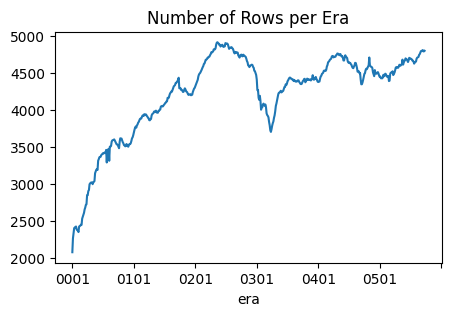

In [36]:
# Let's plot the number of rows per era
# This corresponds to the number stocks in Numerai's investable universe over time
training_data.groupby("era").size().plot(title="Number of Rows per Era", figsize=(5, 3));

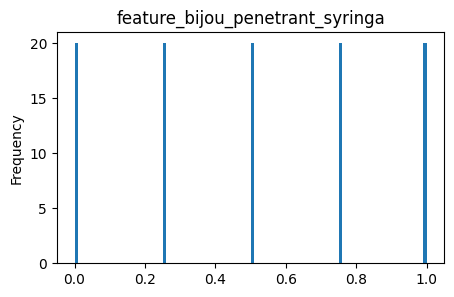

In [37]:
# Feature values are all between 0 and 1 and binned into 5 equal bins 
training_data[feature_cols[0]].plot(kind="hist", bins=100, density=True, figsize=(5, 3), title=feature_cols[0]);

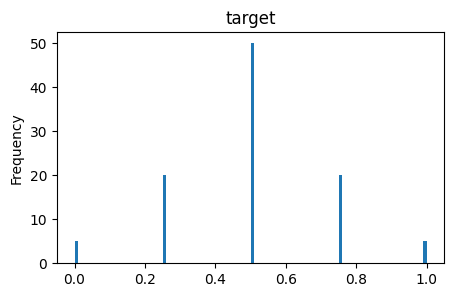

In [38]:
# The target value is also between 0 and 1 but binned into 5 unequal bins
training_data["target"].plot(kind="hist", bins=100, density=True, figsize=(5, 3), title="target");

## 2. Modeling
Our task is to train machine learning models to predict the target. 

Let's train our first model and evaluate its performance with the validation dataset.

In [39]:
# Let's train a simple model using LightGBM
# This will take about 2 minutes 🍵
import lightgbm as lgb

try: 
   # Load trained model if it exists
   model = lgb.Booster(model_file='small_model.txt')
except:
   # Otherwise train and save the model
   model = lgb.LGBMRegressor(
      n_estimators=2000,
      learning_rate=0.01,
      max_depth=5,
      num_leaves=2 ** 5,
      colsample_bytree=0.1
   )
   model.fit(
      training_data[feature_cols],
      training_data["target"]
   );
   model.booster_.save_model("small_model.txt")

# 3. Submissions
Unlike Kaggle competitions where models are often evaluated based on their performance on a hold out test set, Numerai evaluates models based only on their <ins>live performance</ins> in the real stock market.

To participate in the tournament, your model must submit predictions on live features released every day constructed with the latest stock market data where the target values are unknown as they describe future returns. Once the returns and targets become known, your model will recieve live scores that make up your model's live performance.

Here is the basic flow of how to make a single live submission:

In [40]:
# Download latest live features
napi.download_dataset("v4.1/live.parquet");

# Load live features
live_features = pd.read_parquet("v4.1/live.parquet", columns=feature_cols)

# Generate live predictions
live_predictions = model.predict(live_features[feature_cols])

# Format submission
submission = pd.Series(live_predictions, index=live_features.index).to_frame("prediction")
submission

2023-04-17 16:08:55,261 INFO numerapi.utils: target file already exists
2023-04-17 16:08:55,262 INFO numerapi.utils: download complete


,prediction
id,
n0005acb3f491673,0.513076
n0010ad54d91b603,0.506304
n00111241e8d98e2,0.490722
n0022ed91c27e3d8,0.503391
n00586f061b5ba2b,0.488614
...,...
nffdcb9d61c1b421,0.506940
nfff177f4c94b4a5,0.506230
nfff45d84a929a83,0.499324


The easiest way to make live submissions every day is to <ins>upload your entire model pipeline</ins> to Numerai and let us take care of running it daily. This service is free and we support most frameworks like scikit-learn, pytorch, tensorflow etc and is highly recommended to all new users. 

If you don't want to upload your model, you can also choose to setup your own infrastructure to host your model and integrate with our API via webhook or cron. 

In this example we will choose the easy way and upload our model. Here is how you can pickle your model into a file that can be uploaded to Numerai. 

In [41]:
# Define any function that takes live features and returns live predictions
def predict(live_features):
    live_predictions = model.predict(live_features[feature_cols])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")

# Use the cloudpickle library to serialize your function and its dependencies
import cloudpickle
p = cloudpickle.dumps(predict)
with open("predict.pkl", "wb") as f:
    f.write(p)

In [42]:
# Download the model file if running in Google Colab
try:
  from google.colab import files
  files.download('predict.pkl')
except:
  pass

That's it! Now head back to [numer.ai](numer.ai) to upload your model! 